# Calculating the mode-field of a photonic crystal slab


Here's a quick tutorial on how to:
- use $S^4$ to generate the field energy of the guided mode resonances in a photonic crystal slab (PCS) for a single unit cell, 
- and to visualize it in Python

A similar script was used to generate the figures found in our recent paper, 
 <a href="https://www.osapublishing.org/ol/abstract.cfm?uri=ol-46-14-3372">Real-time ultrasound sensing with a mode-optimized photonic crystal slab </a>, also available
 <a href="https://arxiv.org/abs/2105.07846">on the arXiv </a>.


Here are the parameters of the PCS unit cell we will be simulating (see Fig. 1 below):
- square lattice 
- $a = 1.01\ \mu$m - lattice constant 
- layer structure:
    - n = 1.48 overlayer (semi-infinite thickness) 
    - n = 2.0  nitride layer (0.25 $\mu{m}$ thickness)
    - n = 1.444 silicon dioxide (semi-infinite thickness)

- patterning: $r = 0.3 \mu{m}$ nanohole in the center of the unit cell



 <figure>
  <img src="img\PCS_Xsection.png" alt="PCS geometry" style="width:500px;">
  <figcaption><center>Fig. 1  PCS geometry.</center></figcaption>
</figure> 
<!-- 
<img src="Pic.png " alt="PCS geometry" style="width:500px;"/>
Fig. 1  PCS geometry
 -->

### Let's first create the simulation object (geometry, materials indices, etc)

In [1]:
import S4
import numpy as np
from IPython.display import set_matplotlib_formats

#inline figures, that are vector graphics-based
%matplotlib inline
set_matplotlib_formats('svg')

from matplotlib.pyplot import figure, plot
import matplotlib.pyplot as plt


import time

#import S4 helper file
try: 
    import Dependencies.SpectralScan as SpecScan
except:
    import SpectralScan as SpecScan




#define the simulation object... 
def DefineSimulation():

    # all values in microns
    tSiN = 0.25 # microns
    a = 1.01    # microns
    r = 0.3     # microns 
    
    # define the square lattice:
    S = S4.New( Lattice=((a,0),(0,a)) , NumBasis=30)
    
    # Define Materials to be used:
    #indices**2 at 1550 nm
    S.SetMaterial(Name = 'Overlayer', Epsilon = 1.48**2 + 0j) # corresponds to PMMA index @ 1550 nm
    S.SetMaterial(Name = 'SiN',   Epsilon = 2.00**2 + 0j)   # stoichiometric Si3N4
    S.SetMaterial(Name = 'SiO',   Epsilon = 1.444**2 + 0j)  # thermal SiO2, fused silica

    # Add Layers - 3 layers, 
    # the oouter ones are semi-infinite
    #           laynername, thickness, material
    S.AddLayer('layer0',    0      ,  'Overlayer')  # a thickness of 0 means it's a semi-infinite layer
    S.AddLayer('layer1',    tSiN   ,  'SiN')
    S.AddLayer('layer2',    0  ,  'SiO')       #silicon dioxide, semi-infinite layer

    
    # Add Patterning   
    # pattern a nanohole of radius r into the center of the unit cell
    # do the patterning in 'layer1' (SiN) and fill the nanohole with the material 'Water'
    S.SetRegionCircle('layer1', 'Overlayer', Center = (0,0), Radius=r)  
           
    # excite with normal incidence 
    # s-polarization means electric field is normal to the plane of incidence
    # light in the form of a planewave is launched from the top-layer (layer0)
    S.SetExcitationPlanewave( IncidenceAngles=(0,0), # normal incidence
                             sAmplitude  = 1, pAmplitude  = 0, 
                             Order = 0)
    return S



Before we go further, a quick note about the axes convention (Fig. 1):
- The x- and y-directions in S4 define the plane on which the PCS lies.  
- The z-direction is the direction normal to this plane.  

Since the first layer ($z<0$) is a semi-infinite layer, the interface between the first layer and the Silicon Nitide layer will be defined as $z=0$.  

When we move to $z > 0.25 \mu{m}$, we will then be in the semi-infinite SiO2 layer.  

### To illustrate these points, let's create a function that spits out the relative permittivity as a function of (x,y,z).  

In [2]:
# Epsilons = DefineEpsilon(xs,ys,zs, (tSiN,Rcore,nClad, nSiN, nSiO))
def DefineEpsilon(x,y,z, Details=    (0.25,0.3,  1.48,2.0, 1.444)):
    # assuming a 3-layer structure... 
    # and that tSiN, Rcore, nClad, and nSiN, and nSiO are defined
    tSiN, Rcore, nClad, nSiN, nSiO = Details
    xflat = x.flat  # turn N-dimensional array into 1D array.  
    yflat = y.flat
    zflat = z.flat
    Epsilons = np.nan * zflat.copy()
    
    Epsilons[zflat<0]  = nClad**2  # z<0 - means Overlay cladding (n=1.48)
    #we're in the SiN layer
    Epsilons[(0<=zflat[:])&(zflat[:]<=tSiN)&((xflat[:]**2 + yflat[:]**2)<= Rcore**2)] = nClad**2 # portion of SiN  that contains nanohole
    Epsilons[(0<=zflat[:])&(zflat[:]<=tSiN)&((xflat[:]**2 + yflat[:]**2)>  Rcore**2)] = nSiN**2  # portion of SiN layer is not a nanohole
    Epsilons[tSiN<zflat]= nSiO**2   #SiO2 layer
    
    return Epsilons.reshape(x.shape)
     


### Let's now calculate the spectrum for the TM peak of this particular PCS.  

 
Creating dataset took 3.573s


Text(0.5, 0, 'wavelength (nm)')

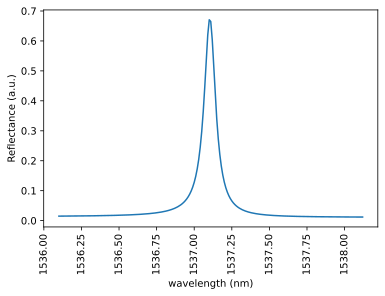

In [3]:
from matplotlib.pyplot import legend


#wavelengths are in microns as well
centerwl = 1537.1e-3
GammaGuess = 0.1e-3  #0.1 nm 
rangewl  = 1e-3      # 1 nm - range for which we will calculate over

startwl, stopwl, res  = (centerwl-rangewl, centerwl+rangewl, GammaGuess/10)

#let's delete any previous instances of the simulation object
try: 
    del S
except:
    print(' ')
 

S = DefineSimulation()


whichlayer = 'layer0'
NumThreads = 2


nAms = []
lambda_data = []
Gamma_data  = []
Peak_data = []


#get the spectrum:
tic = time.time()  
wls, Spectrum = SpecScan.MultiThreadedSpectralScan(S, startwl, stopwl, res, whichlayer, NumThreads)
print("Creating dataset took {:.3f}s".format(time.time() - tic))      


xdata = wls
ydata = np.abs(Spectrum)


figure()
plot(xdata*1e3, ydata)
plt.xticks(rotation= 'vertical')
plt.ylabel('Reflectance (a.u.)')
plt.xlabel('wavelength (nm)')



### Now let's fit that resonance to a Fano peak and extract its  linewidth and peak wavelength 

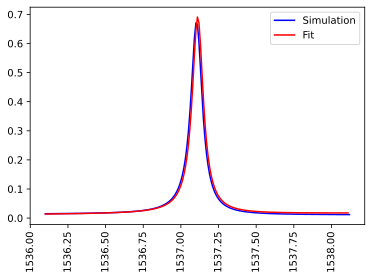

wavelength = 1537.112 nm, linewidth=8.9726e-02 nm


In [4]:
#now extract linewidth and peak wavelength from this plot
try:
    import Dependencies.EricFitter as EF
except:
    import EricFitter as EF
    
lambda0, Linewidth, q, xth, yth, Amplitude, RMSerr = EF.FitFano(xdata, ydata, x0guess = 1537.1e-3, Gammaguess = 0.1, debug = False)

plt.figure()
plt.plot(xdata*1e3, ydata, 'b')
plt.plot(xth*1e3,   yth, 'r')
plt.legend(['Simulation', 'Fit'])
plt.xticks(rotation = 'vertical')

plt.show()
print('wavelength = %2.3f nm, linewidth=%2.4e nm'%(lambda0*1e3, Linewidth*1e3))


### In the following cell, we will calculate the E-fields at the resonance wavelength for an entire unit cell, for $-2 \mu{m} \leq z\leq +2 \mu{m}.$

In [5]:
wl = 1537.112e-3 # in microns

a = 1.01 

#define the grids used to compute the E-fields over
x = np.arange(-0.5, 0.5+0.01, 0.01) * a
y = np.arange(-0.5, 0.5+0.01, 0.0125) * a
z = np.hstack( [np.arange(-2.00, +0.00, 0.010),  #n=1.48 layer
                np.arange(+0.00, +0.25, 0.010),  #SiN layer
                np.arange(+0.25, +2.00, 0.010)]) # SiO n=1.444 layer


ys, xs, zs = np.meshgrid(y,x,z)

Epsilons = DefineEpsilon(xs,ys,zs)


import time


def ComputeEFields(S, xs, ys, zs):    
    '''
    Compute the E-fields for the grid of (xs,ys,zs) points
    '''
    Edata = {"x": 0j+0.*xs.copy(), "y": 0j+0.*xs.copy(), "z": 0j+0.*xs.copy()}    
    
    N = len(xs)
    for k in range(N):
        (E, _) = S.GetFields(xs[k], ys[k], zs[k]) # ignore H field
        Edata["x"][k] = E[0]
        Edata["y"][k] = E[1]
        Edata["z"][k] = E[2]

    return Edata    


#flatten all the arrays:
xsflat = xs.flat
ysflat = ys.flat
zsflat = zs.flat

N = len(zsflat)

S.SetFrequency(1/wl)
 
tic = time.time()  

Efields = ComputeEFields(S, xsflat, ysflat, zsflat)

for field_comp in ['x', 'y', 'z']:   
    Efields[field_comp] = Efields[field_comp].reshape(xs.shape)    

print("Creating dataset took {:.3f}s".format(time.time() - tic))  




Creating dataset took 43.574s


### Before visualizing, let's create a color map that looks good in grayscale too (i.e., bright for large values, dark for small values). 

In [6]:
#create heatmap 

Rmap = lambda f: (0<=f<= 0.375)*(f*(1/0.375)) + (0.375 < f)*1; 
Gmap = lambda f: (f<=0.375)*0 + (0.375<f<= 0.75)*((f-0.375)*(1/0.375)) + (0.75 < f)*1; 
Bmap = lambda f: (f<=0.750)*0 + (0.750<f )*((f-0.75)*(1/0.25));

f = np.arange(0,1.01, 0.01).reshape((101, ))

Rvalues = np.array( [Rmap(f_val) for f_val in f])
Gvalues = np.array( [Gmap(f_val) for f_val in f])
Bvalues = np.array( [Bmap(f_val) for f_val in f])

RGBvalues = np.vstack([Rvalues, Gvalues, Bvalues, Bvalues*0+1]).transpose()



import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#Dump the colormap into matplotlib
New_cmap = cm.get_cmap('viridis', 12)
New_cmap.values = RGBvalues

### We can now finally visualize the field mode energy.  

Play around with the Slice variable to look at the field mode profile along different planes: XZ, YZ, XY.   

Text(0.5, 1.0, 'YZ plane')

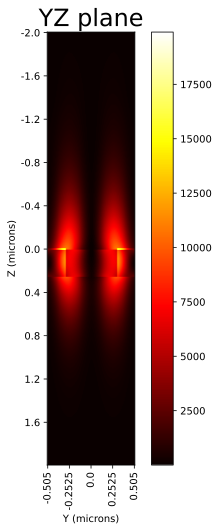

In [7]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# from matplotlib import interactive
# interactive(True)
# %matplotlib qt
%matplotlib inline


xmask = np.argmin(np.abs(x - 0.00)).squeeze()

Slice = 'YZ' # can be 'XZ' and 'XY'


#Python doesn't have switch statements, so... 
if (Slice == 'XZ'):
    ymask = np.argmin(np.abs(y - 0.00)).squeeze()
    axes = ['X', 'Z']
    Epsilons = DefineEpsilon(xs[:,ymask,:],
                             ys[:,ymask,:],
                             zs[:,ymask,:])
    Esquared =  np.abs(Efields['x'][:, ymask, :])**2 + \
                np.abs(Efields['y'][:, ymask, :])**2 +\
                np.abs(Efields['z'][:, ymask, :])**2 
    ax1 = xs[:,ymask,:]
    ax2 = zs[:,ymask,:]
        
if (Slice == 'YZ'):
    xmask = np.argmin(np.abs(x - 0.00)).squeeze()
    axes = ['Y', 'Z']
    Epsilons = DefineEpsilon(xs[xmask,:,:],
                             ys[xmask,:,:],
                             zs[xmask,:,:])
    Esquared =  np.abs(Efields['x'][xmask, :, :])**2 + \
                np.abs(Efields['y'][xmask, :, :])**2 +\
                np.abs(Efields['z'][xmask, :, :])**2 
    ax1 = ys[xmask,:,:]
    ax2 = zs[xmask,:,:]
    
if (Slice == 'XY'):
    zmask = np.argmin(np.abs(z - 0.125)).squeeze()
    Epsilons = DefineEpsilon(xs[:,:,zmask],
                             ys[:,:,zmask],
                             zs[:,:,zmask]) 
    axes = ['X', 'Y']
    Esquared =  np.abs(Efields['x'][:, :, zmask])**2 + \
                np.abs(Efields['y'][:, :, zmask])**2 +\
                np.abs(Efields['z'][:, :, zmask])**2 
    ax1 = xs[:,:,zmask]
    ax2 = ys[:,:,zmask]
    
    


#plot it out! 
fig = plt.figure(figsize=(6,8))
ax = fig.gca()

from matplotlib.ticker import FormatStrFormatter

plothandle = ax.imshow((Esquared * Epsilons).transpose(), cmap = 'hot')
x_position = np.arange(0,len(Esquared[:,1]),int(len(Esquared[:,1])/4.0))
x_ticks = np.round(ax1[x_position,0]* 10000.)/10000.0
plt.xticks(x_position, x_ticks, rotation = 'vertical')

y_position = np.arange(0,len(Esquared[1,:]),int(len(Esquared[1,:])/10.0))
y_ticks = np.round(ax2[0,y_position]* 1000.)/1000.0
plt.yticks(y_position, y_ticks)

fig.colorbar(plothandle, ax = ax)
# ax.set_xlim([-0.51, +0.51])

#larger fonts
plt.rcParams.update({'font.size': 20})
#labels and figure title
plt.xlabel( axes[0]+' (microns)' )
plt.ylabel( axes[1]+' (microns)' )
plt.title(Slice+ ' plane')





### We can also take a look at the fraction of the E-field energy lying in the $n=1.48$ overlayer by performing a simple numerical integration.  

Fractional Power in Overlayer = 0.483
Fractional Power in (Ez-field)  = 0.927
Fractional Power in (Ez-field) in Overlayer  = 0.455


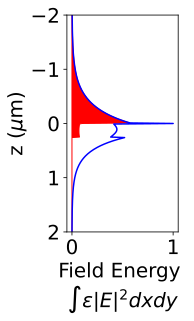

In [8]:
nClad = 1.48 #overlayer index

# get the relative permittivity and get the energey density epsilon|E|^2 
EpsilonsArr = DefineEpsilon(xs,ys,zs)
epsEsquared = zs[1,1,:]* 0 
epsEsquared_Ez_inOverlayer = zs[1,1,:]* 0 
epsEsquared_Ez = zs[1,1,:]* 0 
epsEsquared_inOverlayer = zs[1,1,:]* 0 

#find the energies in each z-layer
#... in the overlayer medium, and everywhere
for k,z in zip(range(len(zs[1,1,:])),zs[1,1,:]):
    for dim in ['x', 'y', 'z']:
        epsEsquared[k] += np.sum( EpsilonsArr[:,:,k] * np.abs(Efields[dim][:,:,k])**2 )
        epsEsquared_inOverlayer[k] += np.sum( (EpsilonsArr[:,:,k] == nClad**2) * EpsilonsArr[:,:,k] * 
                                             np.abs(Efields[dim][:,:,k])**2 )
    epsEsquared_Ez[k] = np.sum( EpsilonsArr[:,:,k] * np.abs(Efields['z'][:,:,k])**2 )
    epsEsquared_Ez_inOverlayer[k] = np.sum( (EpsilonsArr[:,:,k] == nClad**2) * 
                                            EpsilonsArr[:,:,k] * np.abs(Efields['z'][:,:,k])**2 )
        

#draw the epsilon|E|^2 profile. 
figure(figsize=(2,4))
plt.plot(epsEsquared/np.max(epsEsquared), zs[1,1,:], 'b')
# plt.plot(epsEsquared_inOverlayer/np.max(epsEsquared),zs[1,1,:], 'r')
plt.fill_betweenx(zs[1,1,:], epsEsquared_inOverlayer/np.max(epsEsquared), 
                  0*epsEsquared_inOverlayer/np.max(epsEsquared),facecolor='r', edgecolor = 'r')

plt.gca().invert_yaxis()

plt.rcParams.update({'font.size': 16})
plt.ylabel('z ($\mu$m)')
plt.xlabel('Field Energy \n$\int \epsilon |E|^2 dx dy$')
plt.ylim([+2, -2])

# plt.legend(['Total', 'In Overlayer',])

print('Fractional Power in Overlayer = {:.3f}'.format(np.sum(epsEsquared_inOverlayer)/np.sum(epsEsquared)))
print('Fractional Power in (Ez-field)  = {:.3f}'.format(np.sum(epsEsquared_Ez)/np.sum(epsEsquared)))
print('Fractional Power in (Ez-field) in Overlayer  = {:.3f}'.format(np.sum(epsEsquared_Ez_inOverlayer)/np.sum(epsEsquared)))